In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from datetime import date, datetime
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()
sns.set_color_codes()
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)

# column_names = ['# Seen', 'ALSA', '# Picked', 'ATA', '# GP', 'GP WR', '# OH', 'OH WR', '# GD', 'GD WR', '# GIH', 'GIH WR', '# GND', 'GND WR', 'IWD', 'Color', 'Rarity']

from Utilities import Logger
import WUBRG
from data_graphing.LineColors import LineColors
from game_metadata import SETS, FORMATS
from game_metadata import Card,CardManager, SetMetadata, FormatMetadata
from data_fetching import DataLoader, LoadedData, DataFramer, FramedData, SetManager, CentralManager
from data_fetching.utils.date_helper import get_next_17lands_update_time, get_prev_17lands_update_time

LOAD_ALL = False
TRGT_SET = 'SNC'
LOG_LEVEL = Logger.FLG.DEFAULT
LOG_LEVEL

<Flags.DEFAULT: 3>

# Initialization

In [3]:
print(f"Current Local Time:  {datetime.now()}")
print(f"Last 17Lands Update: {get_prev_17lands_update_time()}")
print(f"Current UTC Time:    {datetime.utcnow()}")
print(f"Next 17Lands Update: {get_next_17lands_update_time()}")

Current Local Time:  2022-05-01 22:16:15.121727
Last 17Lands Update: 2022-05-01 02:00:00
Current UTC Time:    2022-05-02 00:46:15.121727
Next 17Lands Update: 2022-05-02 02:00:00


In [4]:
if LOAD_ALL:
    start = datetime.utcnow()
    data_manager = CentralManager()
    data_manager.check_for_updates()
    end = datetime.utcnow()
    print(f"\n --- Data loaded in {end - start}.")

    SNC = data_manager['SNC']
    NEO = data_manager['NEO']
    VOW = data_manager['VOW']
    MID = data_manager['MID']
    set_data = data_manager[TRGT_SET]
else:
    set_data = SetManager(TRGT_SET)
    set_data.check_for_updates()

Loading set metadata for: SNC
Fetching data for set: SNC
Fetching card data for set: SNC
Done!

Checking for missing data for SNC PremierDraft...
Getting overall data for SNC PremierDraft
Getting data for SNC PremierDraft, date: 2022-04-28
Getting data for SNC PremierDraft, date: 2022-04-29
Getting data for SNC PremierDraft, date: 2022-04-30
Finished checking for missing data for SNC PremierDraft.

Checking for missing data for SNC TradDraft...
Getting overall data for SNC TradDraft
Getting data for SNC TradDraft, date: 2022-04-28
Getting data for SNC TradDraft, date: 2022-04-29
Getting data for SNC TradDraft, date: 2022-04-30
Finished checking for missing data for SNC TradDraft.

Checking for missing data for SNC QuickDraft...
SNC QuickDraft has no summary data to get!
SNC QuickDraft has no historic data to get!
Finished checking for missing data for SNC QuickDraft.



# Objects

In [5]:
import sys
try:
    del sys.modules["data_graphing"] 
    del data_graphing
except:
    pass

from data_graphing import ColorHandler, PlotterHelper

In [6]:
class FramedDataFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._ARCH_FUNCS = ArchFuncs(self._DATA)
        self._SNGL_CARD_FUNCS = SingleCardFuncs(self._DATA)
    
    @property
    def SET(self):
        """The draft set."""
        return self._DATA.SET
    
    @property
    def FULL_SET(self):
        """The full name of the draft set."""
        return self._DATA.FULL_SET
    
    @property
    def FORMAT(self):
        """The format type."""
        return self._DATA.FORMAT
    
    @property
    def SHORT_FORMAT(self):
        """The shorthand of the format type."""
        return self._DATA.FULL_FORMAT
    
    @property
    def DATA(self):
        """The object which contains the data about the set and format."""
        return self._DATA
        
    def check_for_updates(self):
        """Populates and updates all data properties, filling in missing data."""
        self._DATA.check_for_updates()

    def reload_data(self):
        """Populates and updates all data properties, reloading all data."""
        self._DATA.reload_data()  
    
    def deck_group_frame(self, name=None, date=None, summary=False):
        """Returns a subset of the 'GROUPED_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_group_frame(name, date, summary)
     
    def deck_archetype_frame(self, deck_color=None, date=None, summary=False):
        """Returns a subset of the 'SINGLE_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_archetype_frame(deck_color, date, summary)
    
    def card_frame(self, name=None, deck_color=None, date=None, card_color=None, card_rarity=None, summary=False):
        """Returns a subset of the 'CARD' data as a DataFrame."""
        return self.DATA.card_frame(name, deck_color, date, card_color, card_rarity, summary)
    
    def compress_date_range_data(self, start_date, end_date, card_name=None):
        """Summarizes card data over a provided set of time."""
        return self.DATA.compress_date_range_data(start_date, end_date, card_name)
        
    
    #ArchFuncs
    def get_games_played(self, deck_color):
        return self._ARCH_FUNCS.get_games_played(deck_color)
        
    def get_avg_winrate(self, day=None, arch='All Decks'):
        return self._ARCH_FUNCS.get_avg_winrate(day, arch)
    
    def get_archetype_frame(self, colors, roll=None):
        return self._ARCH_FUNCS.get_archetype_frame(colors, roll)

    def get_archetype_winrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.get_archetype_winrate_history(color_filter, roll)

    def plot_archetype_winrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.plot_archetype_winrate_history(color_filter, roll)       
        
    def get_archetype_playrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.get_archetype_playrate_history(color_filter, roll)

    def plot_archetype_playrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.plot_archetype_playrate_history(color_filter, roll)
    
    
    #SingleCardFuncs
    def get_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.get_card_summary(card_name, colors, roll)

    def plot_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.plot_card_summary(card_name, colors, roll)
    
    def get_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.get_pick_stats(card_name, roll)
    
    def plot_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.plot_pick_stats(card_name, roll)
    
    def card_archetype_performance(self, card_name):
        return self._SNGL_CARD_FUNCS.card_archetype_performance(card_name)
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        return self._SNGL_CARD_FUNCS.stat_archetype_performance(stat_name, color_cols, min_colors, max_colors)

##    # filters = ['exact', 'subset', 'contains', 'adjascent'*]
##    ## TODO: Determine how to handle colourless cards.
##    ## 'exact': 'U' --> 'U'
##    ## 'subset': 'UW' --> 'U', 'W', 'WU'
##    ## 'contains': 'U' --> 'U', 'UW', 'UB', 'UR', 'UG'...
##    ## 'contains': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'superset': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'adjascent': 'UW' --> 'U', 'W', 'UW', 'UG', 'WG', 'UWG'...
##    def card_color_filter(frame, card_color=None, filter_style=''):
##        if card_color is None: 
##            return frame
##        
##            card_color = WUBRG.get_color_identity(card_color)
##            frame = frame[frame['Color'] == card_color]
##            return frame

    
    def compare_card_evaluations(self, start_date, end_date):
        def inner_func(date):
            df = self.card_frame(date=date, deck_color='')
            df.index = [tup[2] for tup in df.index]
            return df

        first = inner_func(date=start_date)
        last = inner_func(date=end_date)
        diff = last[['ALSA', 'ATA', 'Color', 'Rarity']].copy()
        diff['Δ ALSA'] = first['ALSA'] - last['ALSA']
        diff['Δ ATA'] = first['ATA'] - last['ATA']
        return diff[['ALSA', 'Δ ALSA', 'ATA', 'Δ ATA', 'Color', 'Rarity']]


    def get_top(self, column, count=10, asc=True, card_color=None, card_rarity=None, deck_color='', play_lim=None):
        frame = self.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
        frame = frame.sort_values(column, ascending=asc)

        if card_color is not None:
            card_color = WUBRG.get_color_identity(card_color)
            frame = frame[frame['Color'] == card_color]

        if play_lim is not None:
            if type(play_lim) is float: play_lim *= self.get_games_played(deck_color)
            print(f'Minimum Games played to be included: {play_lim}')
            frame = frame[frame['# GP'] >= play_lim]

        return frame.head(count)

In [7]:
from data_graphing import ROLL
from WUBRG.consts import COLOR_PAIRS

class ArchFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        
    def get_games_played(self, deck_color):
        if deck_color: return self._DATA.deck_archetype_frame(deck_color=deck_color, summary=True)['Games'].sum()
        else: return self._DATA.deck_group_frame(name='All Decks', summary=True)['Games']
    
    def get_avg_winrate(self, day=None, arch='All Decks'):
        if day: return self._DATA.deck_group_frame(date=day, summary=False).loc[(day, arch)]['Win %']
        else: return self._DATA.deck_group_frame(date=day, summary=True).loc[arch]['Win %']   
    
    def get_archetype_frame(self, colors, roll=None):
        if roll is None: roll = ROLL
        win_rate_frame = self._DATA.deck_archetype_frame(deck_color=colors)
        win_rate_frame.index = [tup[0] for tup in win_rate_frame.index]
        #win_rate_frame = win_rate_frame[['Splash', 'Games', 'Win %']]
        win_rate_frame = win_rate_frame[win_rate_frame['Splash'] == False][['Wins', 'Games']]
        rolling = win_rate_frame.rolling(window=roll, min_periods=1, center=True).mean().round()
        rolling['Win %'] = round((rolling['Wins'] / rolling['Games']) * 100, 2)
        rolling['Avg. Win%'] = [self.get_avg_winrate(idx) for idx in win_rate_frame.index]
        rolling['2C Win%'] = [self.get_avg_winrate(idx, arch='Two-color') for idx in win_rate_frame.index]
        rolling['Win % Offset'] = rolling['Win %'] - rolling['Avg. Win%']
        return rolling

    def get_archetype_winrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
        d = dict()
        for col in COLOR_PAIRS:
            temp_frame = self.get_archetype_frame(col)
            d[col] = temp_frame['Win %']
        d['AVG'] = temp_frame ['Avg. Win%']
        d['2C'] = temp_frame ['2C Win%']

        test_frame = pd.DataFrame.from_dict(d)
        test_frame.index = [idx[5:] for idx in test_frame.index]
        if color_filter:
            col_filt = [col for col in COLOR_PAIRS if color_filter in col] + ['AVG', '2C'] 
            test_frame = test_frame[col_filt]

        rolling = test_frame.rolling(window=roll, min_periods=1, center=True).mean()
        return rolling

    def plot_archetype_winrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
            
        test_frame = self.get_archetype_winrate_history(color_filter, roll)
        lc = LineColors()
        title = f"Archetype Winrates (from 17Lands)\n{self._DATA.SET} - {self._DATA.FORMAT}"

        col_filt = f"Color Filter: {color_filter}"
        rol_filt = f"Rolling Average: {roll} Days"

        if color_filter and roll > 1:
            title += f"\n{col_filt}  -  {rol_filt}"
        elif color_filter:
            title += f"\n{col_filt}"
        elif roll > 1:
            title += f"\n{rol_filt}"
        
        test_frame.plot(figsize=(20, 10), color=lc.get_col_array(color_filter), title=title, lw=2.5, grid=True)
        plt.xlabel("Date")
        plt.ylabel("Win Percent")
        
        
    #TODO: Implement a more generic version of this that takes in a list of deck colours to include as output. 
    def get_archetype_playrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
        d = dict()
        for col in COLOR_PAIRS:
            d[col] = self.get_archetype_frame(col)['Games']

        test_frame = pd.DataFrame.from_dict(d)
        test_frame.index = [idx[5:] for idx in test_frame.index]
        rolling = test_frame.rolling(window=roll, min_periods=1, center=True).mean()
        total = rolling.sum(axis=1)
        playrate = rolling.divide(list(total),axis=0) * 100

        if color_filter:
            col_filt = [col for col in COLOR_PAIRS if color_filter in col]
            playrate = playrate[col_filt]

        return playrate

    def plot_archetype_playrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
        test_frame = self.get_archetype_playrate_history(color_filter, roll)
        lc = LineColors()
        title = f"Archetpye Playrates (from 17Lands)\n{self._DATA.SET} - {self._DATA.FORMAT}"

        col_filt = f"Color Filter: {color_filter}"
        rol_filt = f"Rolling Average: {roll} Days"

        if color_filter and roll > 1:
            title += f"\n{col_filt}  -  {rol_filt}"
        elif color_filter:
                title += f"\n{col_filt}"
        elif roll > 1:
                title += f"\n{rol_filt}"
        test_frame.plot(figsize=(20, 10), color=lc.get_col_array(color_filter), title=title, lw=2.5, grid=True)
        plt.xlabel("Date")
        plt.ylabel("Percent of Metagame")

In [8]:
from data_graphing import ROLL
from WUBRG import COLOR_COMBINATIONS
from WUBRG.consts import COLOR_PAIRS


class SingleCardFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._COLOR_IDX = 0
        
    def _shorten_data(self, card_name, roll, cols, colors=''):
        frame = self._DATA.card_frame(name=card_name, deck_color=colors)[cols]
        frame.index = [tup[0][5:] for tup in frame.index]
        rolling = frame.rolling(window=roll, min_periods=1, center=True).mean()
        return rolling

    def plot_card_summary(self, card_name, colors='', roll=None):
        if roll is None: roll = ROLL        
        rolling = self._shorten_data(card_name, roll, ['GIH WR', 'GND WR', 'ATA', 'ALSA', '# GP', '# GIH', '# Picked', '# Seen'], colors=colors)
        
        color_dict = {
            'GIH WR' : (0.33, 0.66, 0.41, 0.9),
            'GND WR' : (0.77, 0.31, 0.32, 0.9),
            'ATA' : (0.87, 0.52, 0.32, 0.9),
            'ALSA' : (0.3, 0.45, 0.69, 0.9),
            '# GP' : (0.51, 0.45, 0.7, 0.9),
            '# GIH' : (0.33, 0.66, 0.41, 0.9),
            '# Picked' : (0.87, 0.52, 0.32, 0.9),
            '# Seen' : (0.3, 0.45, 0.69, 0.9)
        }
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_quad_plot(card_name)
        plot_help.accredit()
        plot_help.desc_note(colors=colors, roll=roll)
                
        plot_help.set_labels(y_label="Win Percent", g_x=0, g_y=0)
        plot_help.set_data(rolling, ['GIH WR', 'GND WR'], g_x=0, g_y=0)
        
        plot_help.set_labels(y_label="Pick Number", g_x=0, g_y=1)
        plot_help.set_data(rolling, ['ALSA', 'ATA'], inv_y=True, g_x=0, g_y=1)
        
        plot_help.set_labels(x_label="Date", y_label="# of Games", g_x=1, g_y=0)
        plot_help.set_data(rolling, ['# GP', '# GIH'], g_x=1, g_y=0)

        plot_help.set_labels(x_label="Date", y_label="# of Cards", g_x=1, g_y=1)
        plot_help.set_data(rolling, ['# Seen', '# Picked'], g_x=1, g_y=1)
        
        
        plot_help.save_fig(f"pcs_{card_name}_{colors}.png")
    
    
    def plot_pick_stats(self, card_name, roll=None):
        if roll is None: roll = ROLL        
        taken_data = self._shorten_data(card_name, roll, ['ALSA', 'ATA'])
        
        plot_help = PlotterHelper(self._DATA)
        fig, ax = plot_help.new_single_plot(card_name)
        plot_help.accredit()
        plot_help.desc_note(roll=roll)
        
        plot_help.set_labels(x_label="Date", y_label="Pick Number")
        plot_help.set_data(taken_data, ['ALSA', 'ATA'], inv_y=True)
        
        plot_help.save_fig(f"pps_{card_name}.png")


    def card_archetype_performance(self, card_name):
        d = dict()
        d['AVG'] = self._DATA.card_frame(card_name, '', summary=True)
        for col in COLOR_PAIRS:
            d[col] = self._DATA.card_frame(card_name, col, summary=True)

        test_frame = pd.DataFrame.from_dict(d).T
        return test_frame
    
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        series = self._DATA.card_frame(summary=True)[stat_name]
        frame = series.reset_index(level=0)
        ret = pd.pivot_table(frame, index='Name', columns='Deck Colors')
        ret.columns = ret.columns.droplevel(0)
        ret = ret[COLOR_COMBINATIONS]  #Re-orders the columns in WUBRG order
        if color_cols is not None:
            ret = ret[color_cols]
        return ret

# Examine Data

In [9]:
set_data.BO1.DATA.CARD_HISTORY_FRAME

# Seen  ALSA  # Picked  \
Date       Deck Colors Name                                               
2022-04-28             Angelic Observer             660 4.789        81   
                       Backup Agent                1965 5.346       262   
                       Ballroom Brawlers            509 3.605       108   
                       Boon of Safety              2342 6.952       216   
                       Brokers Initiate            2206 7.150       215   
...                                                 ...   ...       ...   
2022-04-30 WUBRG       Spara's Headquarters         524 1.981       243   
                       Tramway Station            11783 5.249      2173   
                       Waterfront District        11754 5.321      2281   
                       Xander's Lounge              565 2.097       236   
                       Ziatora's Proving Ground     510 2.059       220   

                                                   ATA  # GP  GP WR  # OH  \
Date       Deck Colors Name                                                 
2022-04-28             Angelic Observer          6.531   118 53.390    12   
                       Backup Agent              7.714   597 58.794   106   
                       Ballroom Brawlers         4.139   179 49.162    22   
                       Boon of Safety           10.440   208 53.846    29   
                       Brokers Initiate         10.781   185 54.054    41   
...                                                ...   ...    ...   ...   
2022-04-30 WUBRG       Spara's Headquarters      2.206    11 54.545     5   
                       Tramway Station           7.228   258 52.713    41   
                       Waterfront District       7.262   232 53.448    45   
                       Xander's Lounge           2.347    25 44.000     4   
                       Ziatora's Proving Ground  2.091    24 41.667     5   

                                                 OH WR  # GD   GD WR  # GIH  \
Date       Deck Colors Name                                                   
2022-04-28             Angelic Observer         58.333    38  57.895     50   
                       Backup Agent             60.377   169  62.130    275   
                       Ballroom Brawlers        50.000    47  55.319     69   
                       Boon of Safety           51.724    50  58.000     79   
                       Brokers Initiate         56.098    41  58.537     82   
...                                                ...   ...     ...    ...   
2022-04-30 WUBRG       Spara's Headquarters     60.000     1 100.000      6   
                       Tramway Station          46.341    82  57.317    123   
                       Waterfront District      55.556    57  56.140    102   
                       Xander's Lounge          50.000     6  50.000     10   
                       Ziatora's Proving Ground 20.000     4  50.000      9   

                                                GIH WR  # GND GND WR     IWD  \
Date       Deck Colors Name                                                    
2022-04-28             Angelic Observer         58.000     70 50.000   8.000   
                       Backup Agent             61.455    322 56.522   4.933   
                       Ballroom Brawlers        53.623    110 46.364   7.260   
                       Boon of Safety           55.696    129 52.713   2.983   
                       Brokers Initiate         57.317    103 51.456   5.861   
...                                                ...    ...    ...     ...   
2022-04-30 WUBRG       Spara's Headquarters     66.667      5 40.000  26.667   
                       Tramway Station          53.659    135 51.852   1.807   
                       Waterfront District      55.882    130 51.538   4.344   
                       Xander's Lounge          50.000     15 40.000  10.000   
                       Ziatora's Proving Ground 33.333     15 46.667 -13.333   

  

In [10]:
examiner = FramedDataFuncs(set_data.BO1)

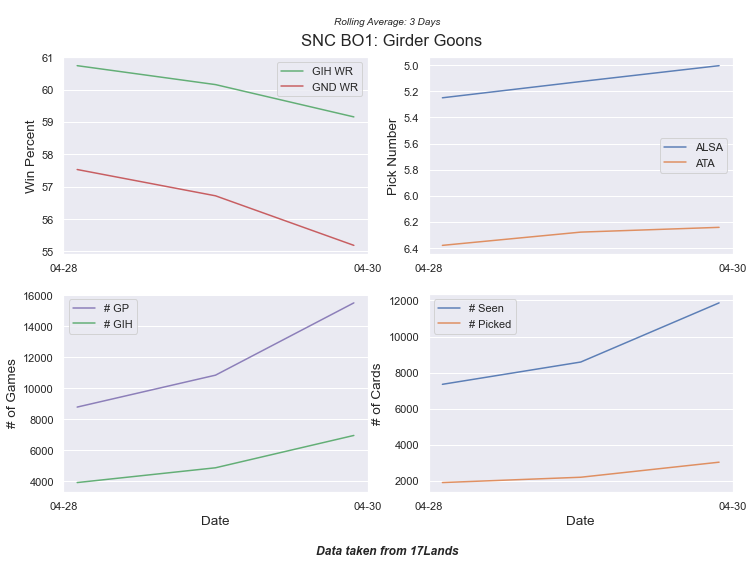

In [11]:
examiner.plot_card_summary('Girder Goons')

In [12]:
examiner._SNGL_CARD_FUNCS._shorten_data('Girder Goons', 3, ['GIH WR', 'GND WR', 'ATA', 'ALSA', '# GP', '# GIH', '# Picked', '# Seen'])

,GIH WR,GND WR,ATA,ALSA,# GP,# GIH,# Picked,# Seen
04-28,60.739,57.531,6.380,5.250,"8,784.000","3,903.500","1,910.000","7,354.000"
04-29,60.154,56.718,6.278,5.125,"10,847.667","4,860.000","2,205.667","8,589.000"
04-30,59.156,55.186,6.242,5.003,"15,521.500","6,950.500","3,039.500","11,866.500"


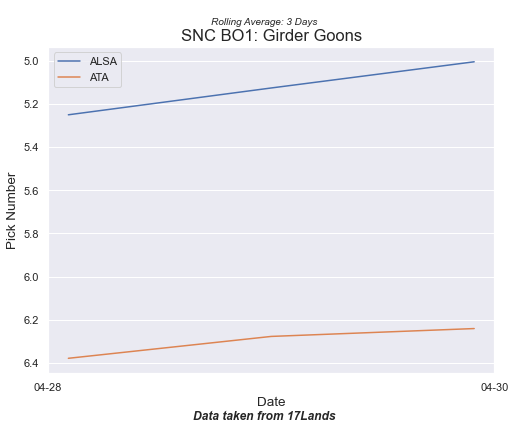

In [13]:
examiner.plot_pick_stats('Girder Goons')

In [14]:
examiner.card_archetype_performance('Girder Goons')

,# Seen,ALSA,# Picked,ATA,# GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GND,GND WR,IWD,Rarity,Color,Cast Color,CMC,Type Line,Supertypes,Types,Subtypes,Power,Toughness
AVG,25767,5.040,6617,6.263,32543,57.149,5371,57.177,9209,60.539,14580,59.300,18007,55.401,3.900,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
WU,25767,5.040,6617,6.263,79,68.354,13,76.923,25,76.000,38,76.316,41,60.976,15.340,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
WB,25767,5.040,6617,6.263,196,62.755,27,59.259,64,70.312,91,67.033,105,59.048,7.985,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
WR,25767,5.040,6617,6.263,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.000,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
WG,25767,5.040,6617,6.263,9,44.444,2,50.000,5,60.000,7,57.143,4,50.000,7.143,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
UB,25767,5.040,6617,6.263,2304,59.592,380,61.579,723,63.624,1103,62.919,1204,56.561,6.358,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
UR,25767,5.040,6617,6.263,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.000,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
UG,25767,5.040,6617,6.263,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.000,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
BR,25767,5.040,6617,6.263,8718,59.475,1455,61.031,2229,61.418,3684,61.265,5047,58.134,3.131,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4
BG,25767,5.040,6617,6.263,222,55.405,41,56.098,45,68.889,86,62.791,136,50.735,12.055,C,B,B,5.000,Creature — Ogre Warrior,None,[Creature],"[Ogre, Warrior]",4,4


In [15]:
examiner.stat_archetype_performance('GIH WR')

KeyError: "['G'] not in index"

In [ ]:
raise Exception('Stopping Auto-Run!')

## Current Tests

In [ ]:
def gt(x, y):  #Used for function pointer shenanigans
    return x > y

def lt(x, y):  #Used for function pointer shenanigans
    return x < y

def filter_quadrant_cards_df(func1, func2, iwd_thresh=0, play_lim=0.01, card_rarity=None, deck_color=''):
    frame = set_data.BO1.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
    
    # TODO: Make the mean different based on card rarity so cards aren't moved into incorrect categories.
    
    if play_lim is not None:
        if type(play_lim) is float: play_lim *= set_data.BO1.get_games_played(deck_color)
        print(f'Minimum Games played to be included: {play_lim}')
        frame = frame[frame['# GP'] >= play_lim]
        
    games_played_mean = frame['# GP'].mean()
    cards = frame[func1(frame['IWD'], iwd_thresh)]
    cards = cards[func2(cards['# GP'], games_played_mean)]
    cards = cards.sort_values('IWD', ascending=func1==lt)
    return cards


def get_trap_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_niche_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_staple_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_dreg_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

In [ ]:
get_niche_cards(deck_color='GW', card_rarity='CU')

In [ ]:
set_data.BO1.card_archetype_performance("Era of Enlightenment")

# TODO

- Calculate archetype openess
 - GIH WR & ALSA based
 - 2.25 of a common per draft 
- Improve graphing capabilities
 - Modify Graphs so they also save an image to a cache folder.
 - Implement better graph titles and axes
 - Update functions to be more general, and have DataFrames piped into them.
- Move sets of files into subfolders based on functionality and relationship (DataFetch, Cards, Graphing, Utils, etc.)
- Better group settings and consts into one file/location.

# Data Graphing and Display

## Card Summary

In [ ]:
set_data.BO1.plot_card_summary('Imperial Oath')

In [ ]:
set_data.BO1.plot_card_summary("Befriending the Moths", roll=3)

In [ ]:
set_data.BO1.plot_card_summary("Michiko's Reign of Truth", roll=3)

In [ ]:
set_data.BO1.plot_card_summary("The Fall of Lord Konda", roll=3)

In [ ]:
set_data.BO1.plot_card_summary('Sunblade Samurai', roll=3)

In [ ]:
set_data.BO1.get_top('GIH WR', count=25, asc=False, deck_color='', card_color=None, card_rarity='RM', play_lim=0.005)

## Card Pick Order Stats

In [ ]:
set_data.BO1.plot_pick_stats('Imperial Oath')

In [ ]:
set_data.BO1.plot_pick_stats('Behold the Unspeakable', 3)

In [ ]:
to_graph = ['Imperial Oath', 'Behold the Unspeakable', 'Virus Beetle', 'Network Disruptor', 'Kumano Faces Kakkazan', 'Iron Apprentice']
for card in to_graph:
    set_data.BO1.plot_pick_stats(card, 3)

## Archetype Winrate History

In [ ]:
set_data.BO1.get_archetype_winrate_history()

In [ ]:
set_data.BO1.plot_archetype_winrate_history('')

In [ ]:
set_data.BO3.plot_archetype_winrate_history('')

## Archetype Playrate History

In [ ]:
set_data.BO1.get_archetype_playrate_history()

In [ ]:
set_data.BO1.plot_archetype_playrate_history('')

In [ ]:
set_data.BO3.plot_archetype_playrate_history('')

## Card Pick Order Changes

In [ ]:
diff = set_data.BO1.compare_card_evaluations('2022-02-10', '2022-03-27')
commons = diff[diff['Rarity'] == 'C']
uncommons = diff[diff['Rarity'] == 'U']

In [ ]:
SRT_TRG = 'Δ ATA'
commons.sort_values(SRT_TRG, ascending=False).head(20)

In [ ]:
commons.sort_values(SRT_TRG, ascending=True).head(20)

In [ ]:
uncommons.sort_values(SRT_TRG, ascending=False).head(10)

In [ ]:
uncommons.sort_values(SRT_TRG, ascending=True).head(10)